# Hyperparameter Optimization

1. [Introduction](#1.-Introduction)
2. [Imports](#2.-Imports)
3. [Loading the data](#3.-Loading-the-data)
4. [Evaluating a baseline model](#4.-Evaluating-a-baseline-model)
5. [Recursive Feature Elimination](#5.-Recursive-Feature-Elimination)
    - 5.1 [Evaluating RFECV-Optimal Model](#5.1-Evaluating-RFECV-Optimal-Model)
    - 5.2 [Evaluating A Feature-Pruned Model](#5.2-Evaluating-A-Feature-Pruned-Model)
6. [Hyperparameter Tuning](#6.-Hyperparameter-Tuning)
7. [Final Performance](#7.-Final-Performance)
    - 7.1 LACE Index
    - 7.2 Final Classifier
    - 7.3 Threshold Tuning
8. [Costs and Implementation Strategies](#8.-Costs-and-Implementation-Strategies)
9. [Conclusion](#9.-Conclusion)
10. [Further Work](#10.-Further-Work)
11. [References](#11-References)

# 1. Introduction

In the previous section, we experimented with different sampling methods and models with default hyperparameter settings. Random forest and other tree-based ensemble methods appeared to perform very well while also maintaining computationally efficiency. In this notebook, we attempt to improve our random forest and LGBM models through hyperparameter tuning.

# 2. Imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
sns.set()

from functools import partial
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier


from itertools import product

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

from src.data import load_dataset as ld
from src.models.cost import compute_operational_cost_with_longer_stay, compute_total_readmission_cost, compute_average_operational_cost_with_discharge_planning, compute_average_operational_cost_with_red
from src.models.evaluate import plot_learning_curve, generate_classification_report_from_model, plot_rfecv, plot_feature_importance, get_top_features, plot_roc_with_optimum
from src.models.lace_index import LACEIndexClassifier
from src.models.tuning import generate_objective_function, run_study

RANDOM_SEED = 0

In [2]:
def plot_optimal_features_and_importance(rfecv, X, max_num=15):
    _, axes = plt.subplots(1, 2, figsize=(20, 7))
    plot_rfecv(rfecv, ax=axes[0])
    plot_feature_importance(rfecv.estimator.feature_importances_, X.columns, max_num=max_num, ax=axes[1])
    plt.tight_layout()

In [3]:
def plot_confusion_matrix_for_threshold(y_pred_proba, y_test, threshold, ax=None, title=None):
    y_pred = (y_pred_proba >= threshold).astype('int')
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 7))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-early', 'Early'])
    disp.plot(include_values=True, cmap=plt.cm.Blues, ax=ax, xticks_rotation=0, colorbar=False)
    ax.set_title(title if title is not None else 'Normalized Confusion Matrix')
    ax.grid(False)

In [4]:
def plot_cost_curve(y_pred_proba, targets, thresholds, cost_function, ax=None, title=None):
    total_costs = []
    
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 5))

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype('int')
        total_cost = cost_function(targets, y_pred)
        total_costs.append(total_cost)

    optimal_threshold_index = np.argmin(total_costs)

    ax.plot(thresholds, total_costs)
    ax.plot(thresholds[optimal_threshold_index], total_costs[optimal_threshold_index], color='black', marker='o', label=f'Optimal threshold: {round(thresholds[optimal_threshold_index], 3)}, cost: ${round(total_costs[optimal_threshold_index], 3)}')
    ax.set_title(title if title is not None else 'Estimated Total Operational Cost by Varying Decision Threshold')
    ax.set_xlabel('Decision Threshold')
    ax.set_ylabel('Estimated Total Operational Cost')
    ax.legend()

# 3. Loading the data

We load the data and because we observed that random undersampling tends to perform better, we will undersample our dataset into `X_train_resampled` and `y_train_resampled`.

In [5]:
training_data = ld.load_preprocessed_pickle('train.pkl')
testing_data = ld.load_preprocessed_pickle('test.pkl')
training_data = training_data.reset_index(drop=True)
testing_data = testing_data.reset_index(drop=True)

In [6]:
X_train = training_data.drop(columns=['is_readmitted_early'])
y_train = training_data.is_readmitted_early
X_test = testing_data.drop(columns=['is_readmitted_early'])
y_test = testing_data.is_readmitted_early
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55956, 80), (55956,), (14007, 80), (14007,))

In [7]:
random_undersampler = RandomUnderSampler(random_state=RANDOM_SEED)

In [8]:
X_train_resampled, y_train_resampled = random_undersampler.fit_resample(X_train, y_train)
X_train_resampled.shape, y_train_resampled.shape

((10042, 80), (10042,))

# 4. Evaluating a baseline model

Let's evaluate the random forest's model test performance with default hyperparameter settings.

In [9]:
forest = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

In [10]:
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [11]:
generate_classification_report_from_model(forest, X_train_resampled, y_train_resampled, X_test, y_test)

,Precision,Recall,f2-score,ROC AUC,# of Positive Obs.,# of Negative Obs.,Proportion of Positive Obs.
0,0.126068,0.563694,0.332707,0.62505,5021,5021,0.5


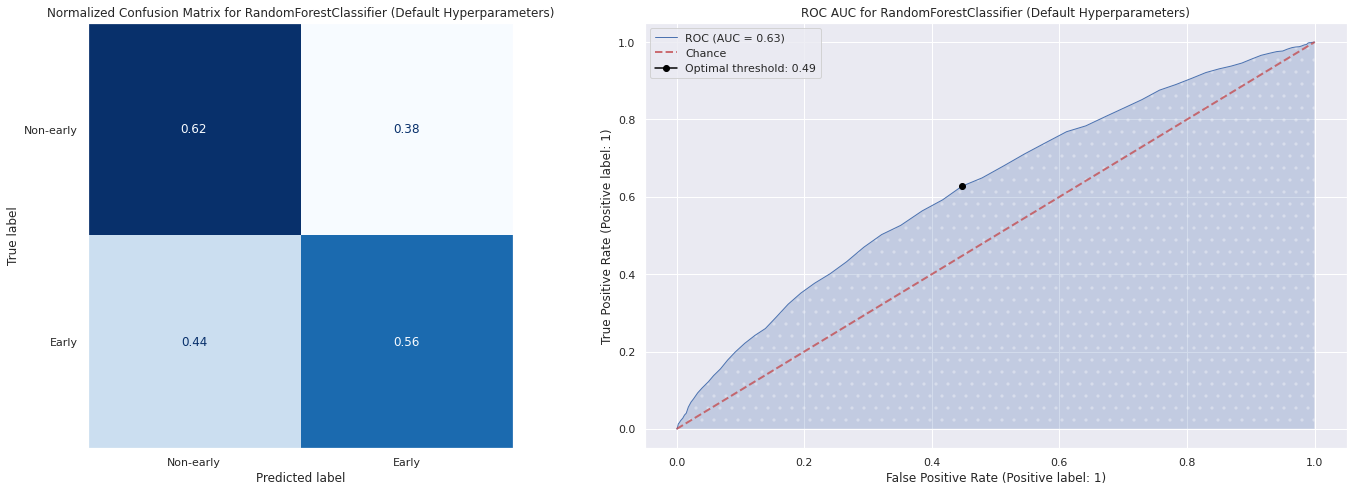

In [12]:
_, axes = plt.subplots(1, 2, figsize=(20, 7))

plot_confusion_matrix(forest, X_test, y_test, display_labels=['Non-early', 'Early'], normalize='true', cmap=plt.cm.Blues, colorbar=False, ax=axes[0])
plot_roc_with_optimum(forest, X_test, y_test, ax=axes[1])

axes[0].set_title('Normalized Confusion Matrix for RandomForestClassifier (Default Hyperparameters)');
axes[0].grid(False)

axes[1].set_title('ROC AUC for RandomForestClassifier (Default Hyperparameters)')

plt.tight_layout()

Our random forest classifer only demonstrates a marginal improvement above chance in identifying early readmission patients, with a recall of only 0.56. We will hopefully see better results after hyperparameter tuning on our training set.

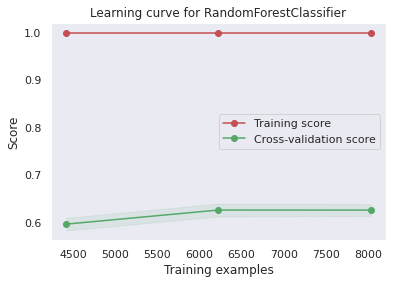

In [13]:
plot_learning_curve(forest, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

Because we do not limit the amount of splits for our default random forest classifier, we expect its training score to be 1. Our ROC AUC does not increase significantly as we increase the number of training examples.

# 5. Recursive Feature Elimination

A nice thing to know is whether a subset of features are superfluous or counterproductive in our classification task. Recursive feature elimination (RFE) is a methodology to remove the weakest features from our dataset, leaving us only with the most relevant feature set. Feature relevance is computed by a model; in this case, the random forest classifier we used earlier.

In [14]:
forest.fit(X_train_resampled, y_train_resampled)
rfecv = RFECV(forest, step=1, cv=StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True), scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train_resampled, y_train_resampled)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
      estimator=RandomForestClassifier(n_jobs=-1, random_state=0), n_jobs=-1,
      scoring='roc_auc')

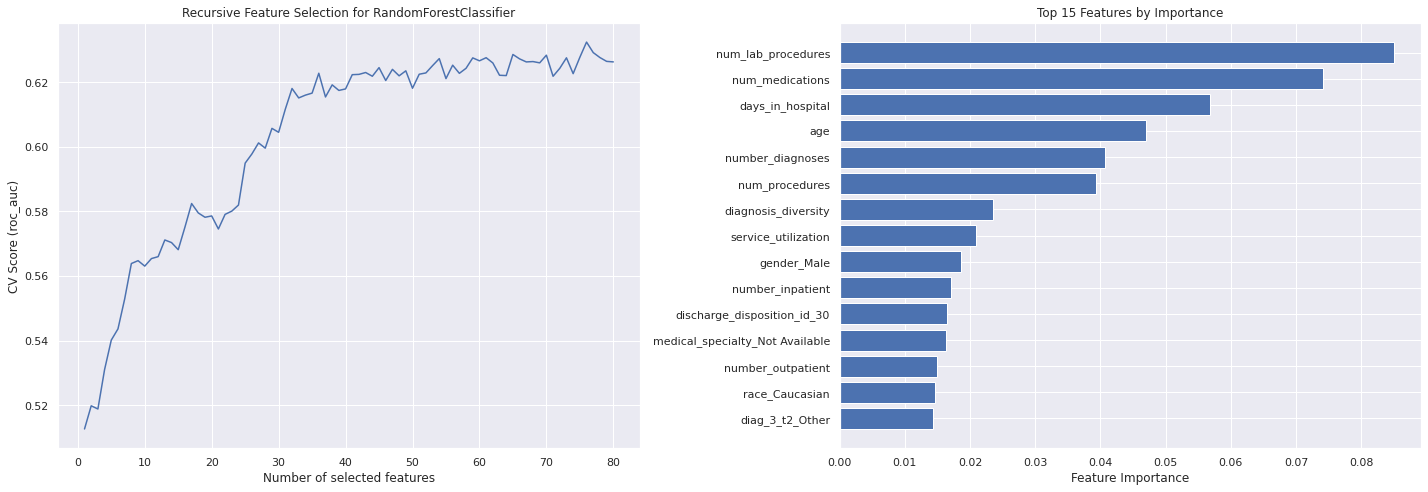

In [15]:
plot_optimal_features_and_importance(rfecv, X_train_resampled)

In [16]:
f'Reduced training dataset of feature size {X_train_resampled.shape[1]} to {rfecv.n_features_}'

'Reduced training dataset of feature size 80 to 76'

In [17]:
f'Dropped feature set {set(X_train_resampled) - set(X_train_resampled.columns[rfecv.support_])}'

"Dropped feature set {'admission_type_id_9', 'pioglitazone_Other', 'gender_Other', 'rosiglitazone_Other'}"

In [18]:
X_train_rfecv = X_train_resampled.loc[:, rfecv.support_]
X_test_rfecv = X_test.loc[:, rfecv.support_]

# Save a pickle to use in our hyperparameter optimization
training_data_rfecv = training_data.drop(columns=['is_readmitted_early']).loc[:, rfecv.support_]
training_data_rfecv['is_readmitted_early'] = training_data.is_readmitted_early
training_data_rfecv.to_pickle(ld.find_preprocessed_path('train_rfecv.pkl'))

testing_data_rfecv = testing_data.drop(columns=['is_readmitted_early']).loc[:, rfecv.support_]
testing_data_rfecv['is_readmitted_early'] = testing_data.is_readmitted_early
testing_data_rfecv.to_pickle(ld.find_preprocessed_path('test_rfecv.pkl'))

Each feature except one is ranked number one, since each feature only provides a marginal amount of importance. This shouldn't change the performance in a meaningful way so we may need to prune the feature set down more for better generalization to unseen data.

## 5.1 Evaluating RFECV-Optimal Model

In [19]:
forest.fit(X_train_rfecv, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [20]:
generate_classification_report_from_model(forest, X_train_rfecv, y_train_resampled, X_test_rfecv, y_test)

,Precision,Recall,f2-score,ROC AUC,# of Positive Obs.,# of Negative Obs.,Proportion of Positive Obs.
0,0.126676,0.556529,0.331531,0.627043,5021,5021,0.5


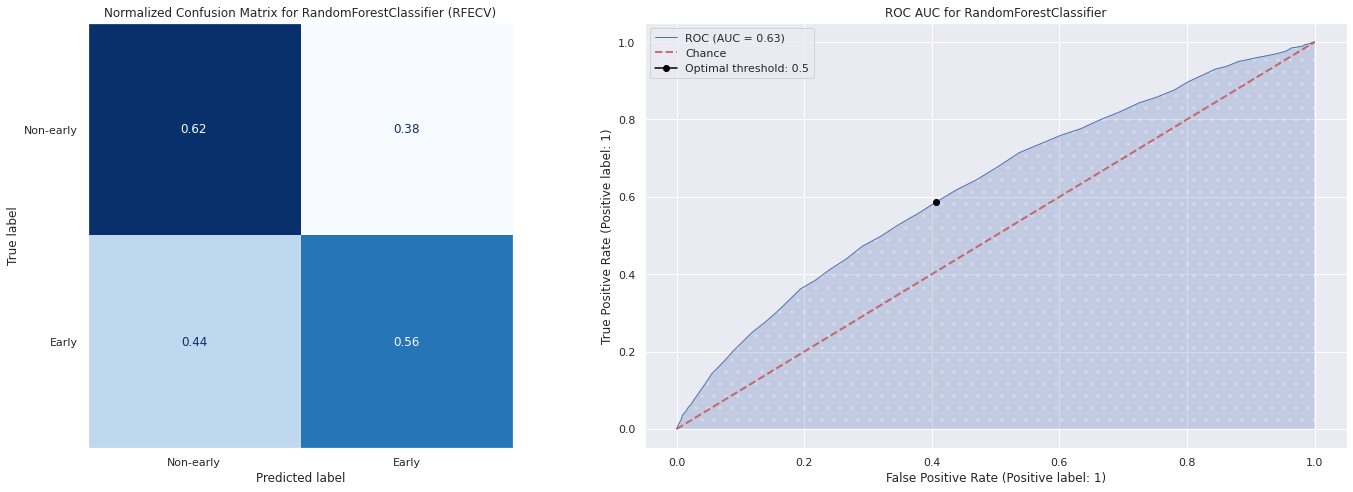

In [21]:
_, axes = plt.subplots(1, 2, figsize=(20, 7))

plot_confusion_matrix(forest, X_test_rfecv, y_test, display_labels=['Non-early', 'Early'], normalize='true', cmap=plt.cm.Blues, colorbar=False, ax=axes[0])
plot_roc_with_optimum(forest, X_test_rfecv, y_test, ax=axes[1])

axes[0].set_title('Normalized Confusion Matrix for RandomForestClassifier (RFECV)');
axes[0].grid(False)
plt.tight_layout()

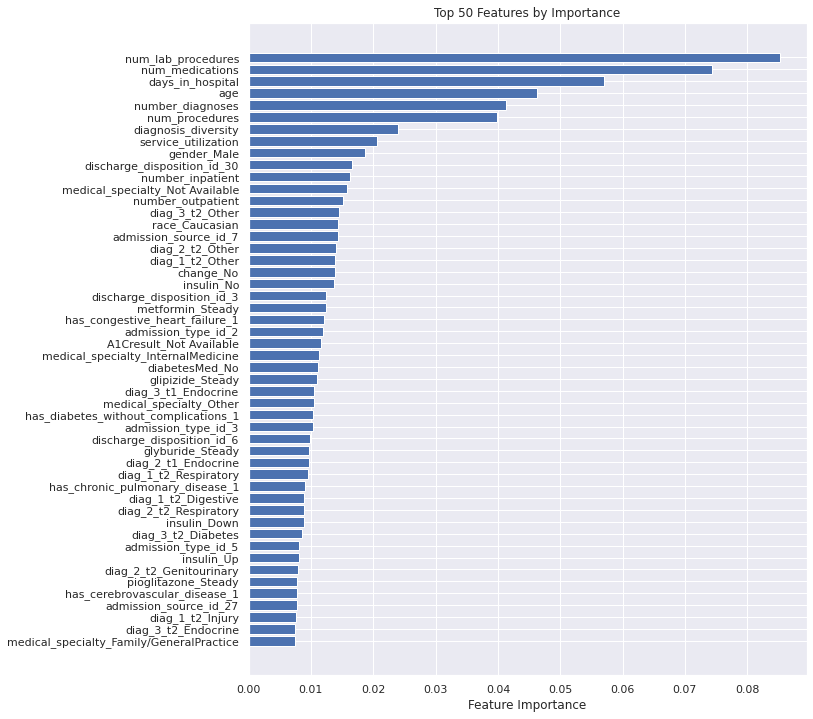

In [22]:
_, ax = plt.subplots(figsize=(10, 12)) 
sorted_importance, sorted_names = plot_feature_importance(forest.feature_importances_, X_train_rfecv.columns, max_num=50, ax=ax)

The model performs similarly, except for a slightly higher recall for non-early readmission patients.

## 5.2 Evaluating A Feature-Pruned Model

There are a handful of features that have a 0.005 feature importance.

In [23]:
pruned_features = sorted_names[:len(sorted_importance[sorted_importance > 0.005])]
X_train_pruned = X_train_resampled.loc[:, pruned_features]
X_test_pruned = X_test.loc[:, pruned_features]
X_train_pruned.shape, X_test_pruned.shape

((10042, 67), (14007, 67))

In [24]:
forest.fit(X_train_pruned, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [25]:
generate_classification_report_from_model(forest, X_test_pruned, y_train_resampled, X_test_pruned, y_test)

,Precision,Recall,f2-score,ROC AUC,# of Positive Obs.,# of Negative Obs.,Proportion of Positive Obs.
0,0.127451,0.569268,0.336186,0.631308,5021,5021,0.5


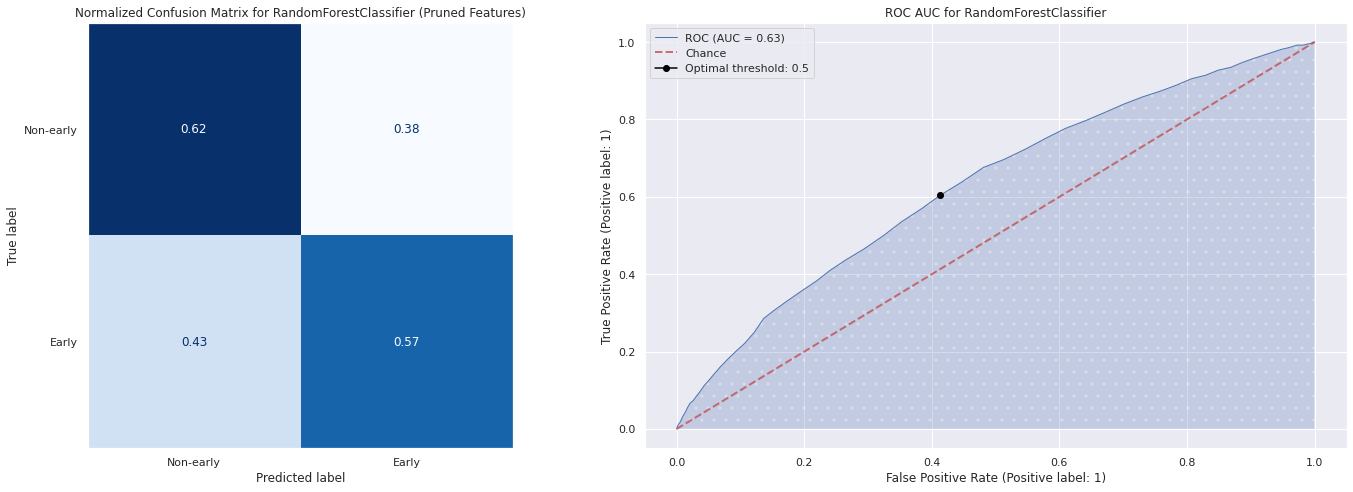

In [26]:
_, axes = plt.subplots(1, 2, figsize=(20, 7))

plot_confusion_matrix(forest, X_test_pruned, y_test, display_labels=['Non-early', 'Early'], normalize='true', cmap=plt.cm.Blues, colorbar=False, ax=axes[0])
plot_roc_with_optimum(forest, X_test_pruned, y_test, ax=axes[1])

axes[0].set_title('Normalized Confusion Matrix for RandomForestClassifier (Pruned Features)');
axes[0].grid(False)
plt.tight_layout()

The pruned feature dataset yields a slightly improved performance. However, we will still experiment with this dataset in hyperparameter optimization.

In [27]:
# Save a pickle to use in our hyperparameter optimization
training_data_pruned = training_data.drop(columns=['is_readmitted_early']).loc[:, pruned_features]
training_data_pruned['is_readmitted_early'] = training_data.is_readmitted_early
training_data_pruned.to_pickle(ld.find_preprocessed_path('train_pruned.pkl'))

testing_data_pruned = testing_data.drop(columns=['is_readmitted_early']).loc[:, pruned_features]
testing_data_pruned['is_readmitted_early'] = testing_data.is_readmitted_early
testing_data_pruned.to_pickle(ld.find_preprocessed_path('test_pruned.pkl'))

Going one step further for the sake of experimentation, we shed even more features by only taking the top 25 most relevant features:

In [28]:
top_25 = sorted_names[:25]
X_train_top_25 = X_train_resampled.loc[:, top_25]
X_test_top_25 = X_test.loc[:, top_25]
np.cumsum(sorted_importance)

array([0.08525405, 0.15959997, 0.21662542, 0.26285845, 0.30415285,
       0.34404091, 0.36801607, 0.3886844 , 0.40729913, 0.42390484,
       0.44024401, 0.4560325 , 0.47120594, 0.48564914, 0.50006709,
       0.51437282, 0.52842668, 0.54232698, 0.55618978, 0.56981539,
       0.58230536, 0.59470561, 0.60684517, 0.61883013, 0.63051446,
       0.64175652, 0.65288391, 0.66393521, 0.67443788, 0.68486753,
       0.69528052, 0.70558429, 0.71544092, 0.72511324, 0.73474112,
       0.74432197, 0.75342247, 0.76239246, 0.77131783, 0.78017771,
       0.78874222, 0.79687243, 0.80500131, 0.81300697, 0.82074827,
       0.82847519, 0.8361953 , 0.84373597, 0.85126234, 0.85874093,
       0.86619841, 0.87350364, 0.88080246, 0.88809857, 0.89533103,
       0.90240601, 0.90910265, 0.91563193, 0.92212578, 0.92839176,
       0.93452229, 0.94054424, 0.94652104, 0.95236943, 0.95816869,
       0.96387802, 0.9692347 , 0.97412232, 0.97887167, 0.98312087,
       0.98633358, 0.98951285, 0.99268269, 0.99531732, 0.99772

The first 25 features capture about 2/3 of the overall feature importance.

In [29]:
forest.fit(X_train_top_25, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=0)

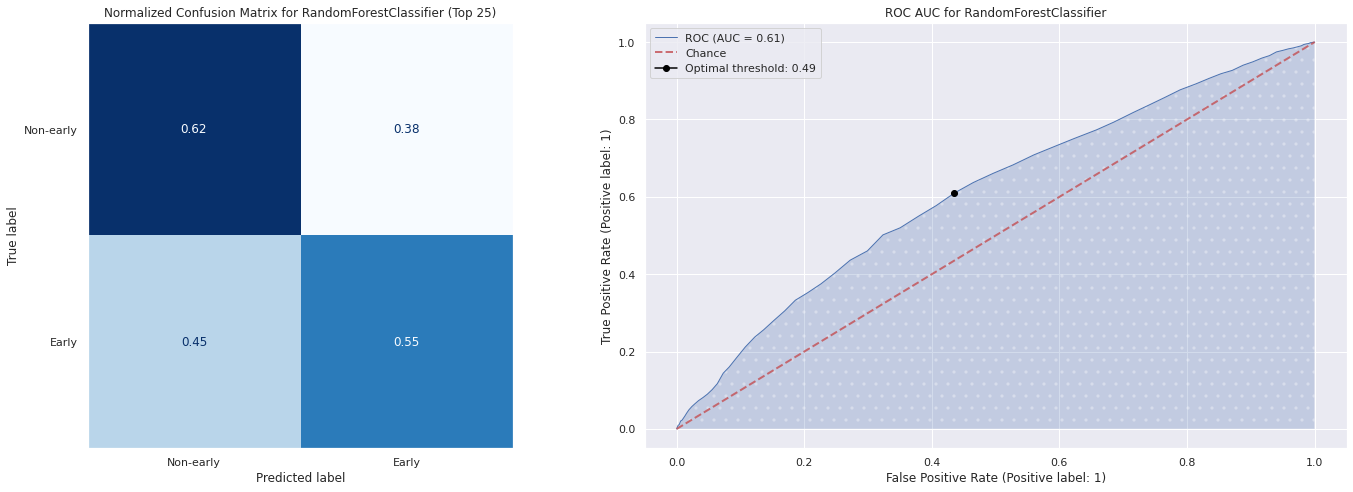

In [30]:
_, axes = plt.subplots(1, 2, figsize=(20, 7))

plot_confusion_matrix(forest, X_test_top_25, y_test, display_labels=['Non-early', 'Early'], normalize='true', cmap=plt.cm.Blues, colorbar=False, ax=axes[0])
plot_roc_with_optimum(forest, X_test_top_25, y_test, ax=axes[1])

axes[0].set_title('Normalized Confusion Matrix for RandomForestClassifier (Top 25)');
axes[0].grid(False)
plt.tight_layout()

In [31]:
# Save a pickle to use in our hyperparameter optimization
training_data_top_25 = training_data.drop(columns=['is_readmitted_early']).loc[:, top_25]
training_data_top_25['is_readmitted_early'] = training_data.is_readmitted_early
training_data_top_25.to_pickle(ld.find_preprocessed_path('train_top_25.pkl'))

testing_data_top_25 = testing_data.drop(columns=['is_readmitted_early']).loc[:, top_25]
testing_data_top_25['is_readmitted_early'] = testing_data.is_readmitted_early
testing_data_top_25.to_pickle(ld.find_preprocessed_path('test_top_25.pkl'))

# 6. Hyperparameter Tuning

We used [Optuna](https://optuna.readthedocs.io/en/stable/), a hyperparameter optimization framework, to more efficiently navigate our hyperparameter search space. We conducted 32 total studies: $M\ \times\ D\ \times\ O$, where:
- $M$ is the model type (random forest, LGBM). These models yielded the consistent cross-validation results in our model selection phase.
- $D$ is the dataset type (undersampled, undersampled + feature selected via RFECV, undersampled + feature selected based on feature importance during k-fold CV, top 25 most relevant features)
- $O$ is our maximization objective (recall, $f\beta$-score ($\beta = \{1, 2\}$), ROC AUC)

In [32]:
def load_study(study_name, file_name=None):
    if file_name is None:
        file_name = study_name
    return optuna.load_study(study_name=study_name, storage=f'sqlite:///../studies/{file_name}.db')

In [33]:
# Models
model__rf          = 'Random Forest'
model__lgbm        = 'LightGBM'

# Datasets
data__original     = 'Original'
data__rfecv        = 'RFECV'
data__pruned       = 'Pruned'
data__top_25       = 'Top_25'

# Objective metrics
objective__recall  = 'recall'
objective__f2      = 'f2'
objective__f1      = 'f1'
objective__roc_auc = 'roc_auc'

type_name_to_dataset = {
    data__original: (X_train_resampled, y_train_resampled, X_test, y_test),
    data__rfecv: (X_train_rfecv, y_train_resampled, X_test_rfecv, y_test),
    data__pruned: (X_train_pruned, y_train_resampled, X_test_pruned, y_test),
    data__top_25: (X_train_top_25, y_train_resampled, X_test_top_25, y_test)
}

model_name_to_model = {
    model__rf: partial(RandomForestClassifier, random_state=RANDOM_SEED, n_jobs=-1),
    model__lgbm: partial(LGBMClassifier, random_state=RANDOM_SEED, n_jobs=-1)
}


models = [model__rf, model__lgbm]
data_types = [data__original, data__rfecv, data__pruned, data__top_25]
objectives = [objective__recall, objective__f2, objective__roc_auc, objective__f1]

studies = []
for m, d, o in product(models, data_types, objectives):
    model_name = m.lower().replace(" ", "_")
    
    if model_name == 'lightgbm':
        model_name = 'lgbm'
    
    study_name = f'{model_name}_{d.lower()}_{o}'
    s = (m, d, o, load_study(study_name))
    studies.append(s)

In [34]:
reports = []
for name, dataset_type, metric, study in studies:
    classifier_cls = model_name_to_model.get(name)
    best_params = study.best_params
        
    if name == model__lgbm:
        aliases = {
            'lambda_l1': 'reg_alpha',
            'lambda_l2': 'reg_lambda',
            'bagging_fraction': 'subsample',
            'bagging_freq': 'subsample_freq',
            'feature_fraction': 'colsample_bytree'
        }
        
        # Reset parameters to their aliases to suppress LGBM warnings
        for param, alias in aliases.items(): 
            if param in best_params:
                best_params[alias] = best_params[param]
                del best_params[param]

    clf = classifier_cls(**best_params)
    x_tr, y_tr, x_te, y_te = type_name_to_dataset.get(dataset_type)
    clf.fit(x_tr, y_tr)
    report = generate_classification_report_from_model(clf, x_tr, y_tr, x_te, y_te, name)    
    report['Objective Metric'] = metric
    report['Dataset Type'] = dataset_type
    report = report.set_index([report.index, 'Dataset Type', 'Objective Metric'])
    reports.append(report)
    
pd.concat(reports, axis=0).drop(columns=['# of Positive Obs.', '# of Negative Obs.', 'Proportion of Positive Obs.'])

Precision    Recall  f2-score  \
              Dataset Type Objective Metric                                  
Random Forest Original     recall             0.129717  0.588376  0.344651   
                           f2                 0.131495  0.592357  0.348249   
                           roc_auc            0.134003  0.562898  0.343204   
                           f1                 0.131010  0.583599  0.345136   
              RFECV        recall             0.131481  0.591561  0.348009   
                           f2                 0.131462  0.589172  0.347320   
                           roc_auc            0.132552  0.576433  0.345222   
                           f1                 0.130866  0.588376  0.346266   
              Pruned       recall             0.129357  0.573248  0.339943   
                           f2                 0.130272  0.580414  0.343220   
                           roc_auc            0.131115  0.574045  0.342583   
                           f1                 0.130175  0.573248  0.341071   
              Top_25       recall             0.129657  0.559713  0.336492   
                           f2                 0.129812  0.555732  0.335545   
                           roc_auc            0.130093  0.554140  0.335454   
                           f1                 0.128978  0.548567  0.332336   
LightGBM      Original     recall             0.128998  0.581210  0.341664   
                           f2                 0.128805  0.582803  0.341832   
                           roc_auc            0.136828  0.565287  0.347596   
                           f1                 0.128941  0.579618  0.341143   
              RFECV        recall             0.129544  0.578822  0.341764   
                           f2                 0.132167  0.583599  0.346736   
                           roc_auc            0.133007  0.562102  0.341657   
                           f1                 0.130986  0.583599  0.345104   
              Pruned       recall             0.128531  0.572452  0.338576   
                           f2                 0.128313  0.582006  0.340920   
                           roc_auc            0.133435  0.557325  0.340798   
                           f1                 0.128617  0.573248  0.338919   
              Top_25       recall             0.124574  0.553344  0.327737   
                           f2                 0.125906  0.566879  0.333365   
                           roc_auc            0.130038  0.544586  0.332555   
                           f1                 0.126753  0.568471  0.334991   

                                              ROC AUC  
              Dataset Type Objective Metric            
Random Forest Original     recall            0.638186  
                           f2                0.640928  
                           roc_auc           0.643159  
                           f1                0.642114  
              RFECV        recall            0.642600  
                           f2                0.641962  
                           roc_auc           0.641002  
                           f1                0.642194  
              Pruned       recall            0.639963  
                           f2                0.641129  
                           roc_auc           0.642379  
                           f1                0.640929  
              Top_25       recall            0.628439  
                           f2                0.627903  
                           roc_auc           0.628946  
                           f1                0.628353  
LightGBM      Original     recall            0.636003  
                           f2                0.632370  
                           roc_auc           0.641720  
                           f1                0.632467  
              RFECV        recall            0.632383  
                           f2                0.639378  
                           roc_auc           0.6

We are prioritizing models that performed well with respect to the recall metric, but also does not sacrifice ROC AUC and F2-measure as they are also important. Our random forest models seemed to perform better on average in all three metrics than our LGBMs. Random forest training on our RFE features yields a high recall and ROC AUC score.

# 7. Final Performance 
In this section, we evaluate our performance of our final model after tuning its hyperparameters. We will then try to tune its decision threshold to determine if it yields better results. First, we evaluate the LACE Index classifier on our test data to establish a performance benchmark. The LACE Index is a simple risk assessment tool to predict likelihood of hospital readmission.

## 7.1 LACE Index

In [35]:
lace_training_data = ld.load_preprocessed_pickle('train_lace.pkl')
lace_training_data = lace_training_data.reset_index(drop=True)
lace_testing_data = ld.load_preprocessed_pickle('test_lace.pkl')
lace_testing_data = lace_testing_data.reset_index(drop=True)

X_lace_train = lace_training_data.drop(columns=['is_readmitted_early'])
y_lace_train = lace_training_data.is_readmitted_early
X_lace_test = lace_testing_data.drop(columns=['is_readmitted_early'])
y_lace_test = lace_testing_data.is_readmitted_early


lace_classifier = LACEIndexClassifier()
lace_classifier.fit(X_lace_train, y_lace_train)
y_pred_lace = lace_classifier.predict(X_lace_test)

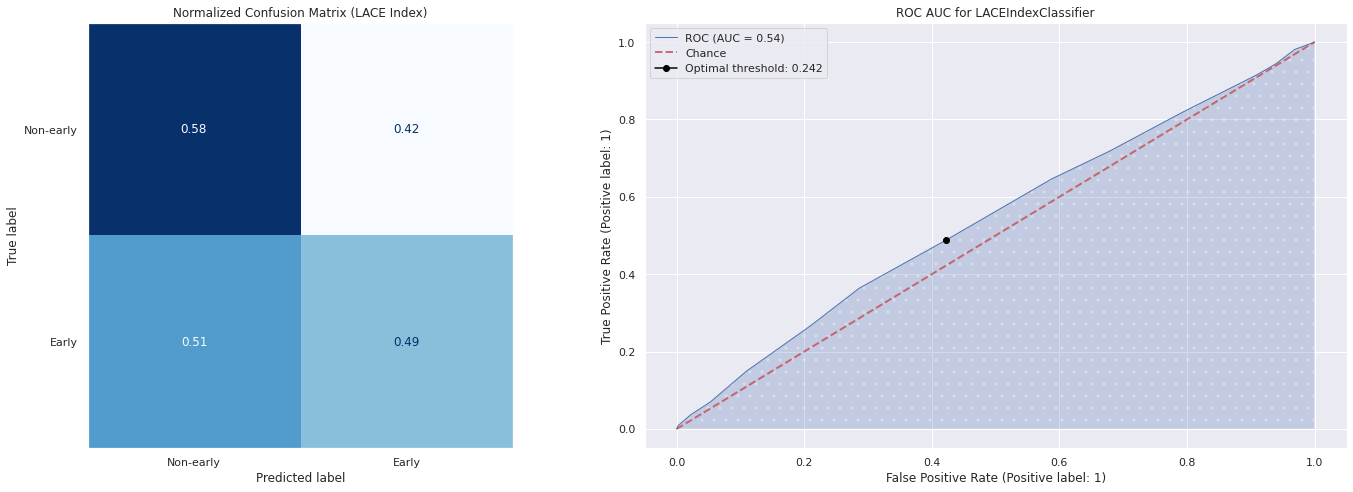

In [36]:
_, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_confusion_matrix(lace_classifier, X_lace_test, y_lace_test, display_labels=['Non-early', 'Early'], normalize='true', cmap=plt.cm.Blues, colorbar=False, ax=axes[0])
plot_roc_with_optimum(lace_classifier, X_lace_test, y_lace_test, ax=axes[1])
axes[0].set_title('Normalized Confusion Matrix (LACE Index)');
axes[0].grid(False)
plt.tight_layout()

The optimal threshold is derived using the training data on which the LACE classifier was fit. The LACE index only yields a performance slightly better than chance. Let's load our best performing study to see if there is a difference.

## 7.2 Final Classifier

In [37]:
best_study = studies[7][3]
best_study.study_name

'random_forest_rfecv_f1'

In [38]:
final_classifier = RandomForestClassifier(random_state=RANDOM_SEED, **best_study.best_params)

In [39]:
final_classifier.fit(X_train_rfecv, y_train_resampled)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=10, min_samples_split=100,
                       n_estimators=657, random_state=0)

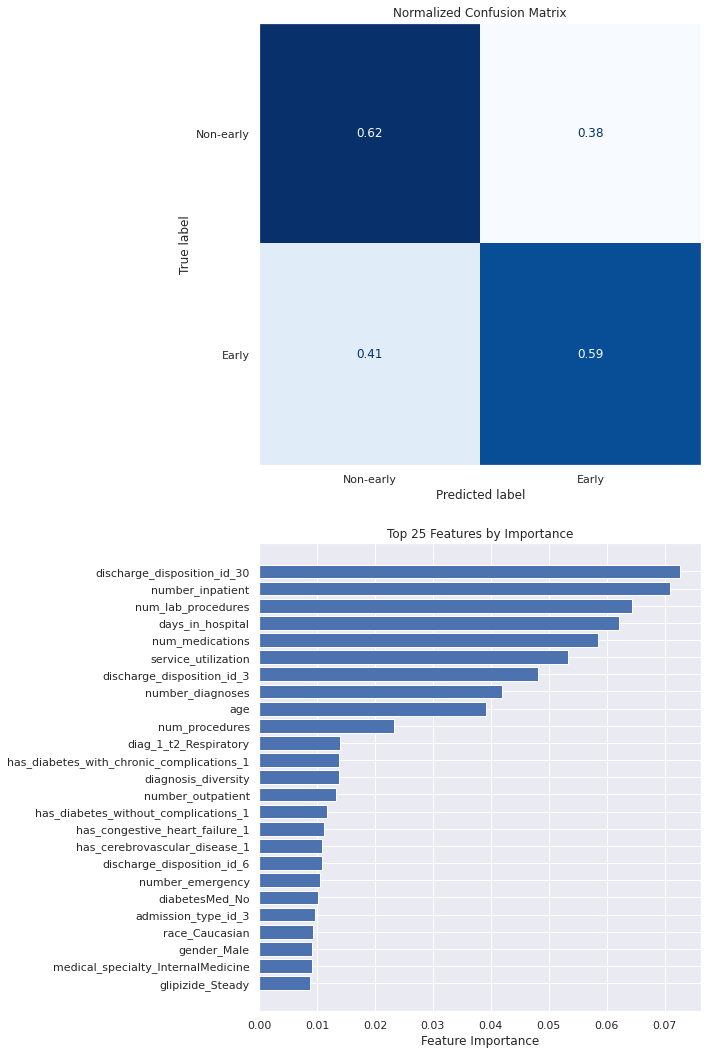

In [40]:
_, axes = plt.subplots(2, 1, figsize=(10, 15))

plot_confusion_matrix(final_classifier, X_test_rfecv, y_test, display_labels=['Non-early', 'Early'], normalize='true', cmap=plt.cm.Blues, colorbar=False, ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')

sorted_importance, sorted_names = plot_feature_importance(final_classifier.feature_importances_, X_test_rfecv.columns, max_num=25, ax=axes[1])

axes[0].grid(False);
plt.tight_layout()

The classifier is able to classify 61% of early readmission patients and 62% of non-early readmission patients correctly in our test set. 

Discharges that did not fall into a category (30) and discharges related to skilled nursing facilities (3) or home health services (6) had high relative importances. 

Days in hospital, number of inpatient encounters, the total number of medications, total number of visits (service_utilization), and age also have a high weight.

Surprisingly, not many of our engineered disease predicates were important to our model, except having diabetes with chronic complications, cerebrovascular disease, or congestive heart failure (all of which are considered by the LACE index). It could be that these predicates were not general enough to sufficiently separate these two groups. For example, only a small amount of early readmitted patients may have had chronic renal disease, which would not yield a sufficient impurity to warrant a split on this attribute. 

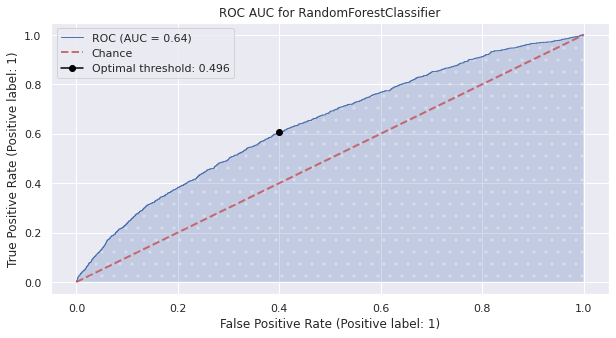

In [41]:
best_threshold_roc = plot_roc_with_optimum(final_classifier, X_test_rfecv, y_test)

Graphing the ROC, we can observe the performance of varying thresholds with respect to the true and false positive rate in classifying all early readmission patients. The area under the ROC, which represents the probability (among all thresholds) of classifying an early readmission patient as a higher rank than a non-early readmission patient, is 0.65. 

We derive the threshold that strikes the optimal balance between true and false positive rates as 0.501.

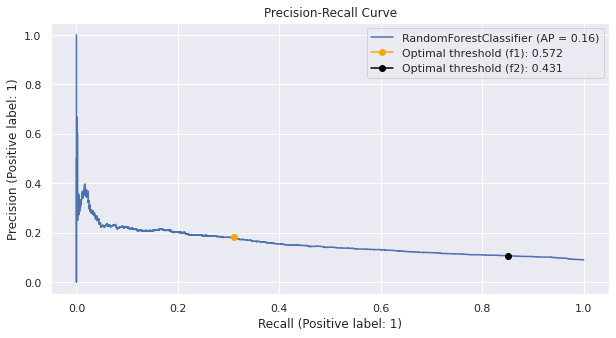

In [42]:
y_pred_proba = final_classifier.predict_proba(X_test_rfecv)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1 =  2 * (precision * recall) / (precision + recall + 1e-7)
f2 = (5 * precision * recall) / (4 * precision + recall + 1e-7)

best_threshold_index_f1 = np.argmax(f1)
best_threshold_f1 = thresholds[best_threshold_index_f1]

best_threshold_index_f2 = np.argmax(f2)
best_threshold_f2 = thresholds[best_threshold_index_f2]

_, ax = plt.subplots(figsize=(10, 5))

plot_precision_recall_curve(final_classifier, X_test_rfecv, y_test, ax=ax)
ax.plot(recall[best_threshold_index_f1], precision[best_threshold_index_f1], color='orange', marker='o', label=f'Optimal threshold (f1): {round(best_threshold_f1, 3)}')
ax.plot(recall[best_threshold_index_f2], precision[best_threshold_index_f2], color='black', marker='o', label=f'Optimal threshold (f2): {round(best_threshold_f2, 3)}')
ax.set_title('Precision-Recall Curve')

plt.legend();

We visualize the relationship between precision and recall in predicting early readmission patients above. We find that the optimal threshold with respect to the f1-score is 0.536 (pictured in yellow). Optimizing based on the f2-score places more weight on the recall metric, which translates to its position on the precision-recall curve (pictured in black) where it's farther along the recall axis, sacrificing precision. The f2-score threshold is 0.486. We can visualize these three thresholds in a different way in the below graph:

In [43]:
def accuracy_by_threshold(y_test, probs, threshold):
    y_pred = probs.copy()
    y_pred = (y_pred >= threshold).astype('int')
    return accuracy_score(y_test, y_pred)

accuracies = [accuracy_by_threshold(y_test, y_pred_proba, t) for t in thresholds]

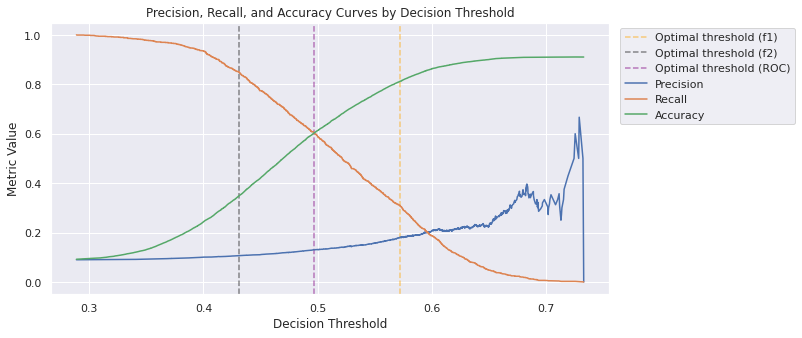

In [44]:
_, ax = plt.subplots(figsize=(10, 5))

ax.axvline(x=best_threshold_f1, linestyle='--', color='orange', alpha=0.5, label='Optimal threshold (f1)')
ax.axvline(x=best_threshold_f2, linestyle='--', color='k', alpha=0.5, label='Optimal threshold (f2)')
ax.axvline(x=best_threshold_roc, linestyle='--', color='purple', alpha=0.5, label='Optimal threshold (ROC)')
ax.plot(thresholds, precision[:-1], label='Precision')
ax.plot(thresholds, recall[:-1], label='Recall')
ax.plot(thresholds, accuracies, label='Accuracy')

ax.set_title('Precision, Recall, and Accuracy Curves by Decision Threshold')
ax.set_ylabel('Metric Value')
ax.set_xlabel('Decision Threshold')
plt.legend(bbox_to_anchor=(1.01, 1));

We visualize precision, recall, and accuracy as a function of varying decision threshold. One thing to note is that accuracy tends to increase the more we increase the decision threshold. This is because of the 9:1 class imbalance that is still present in our test set, as we do not perform any resampling on unseen data. For decision thresholds greater than 0.7, the recall (or the accuracy with which we classify early readmission patients) falls to about zero, meaning we generally aren't extremely confident when predicting the probability that an early readmission patient will readmit early.

## 7.3 Threshold Tuning

How does threshold-moving affect our classification performance?

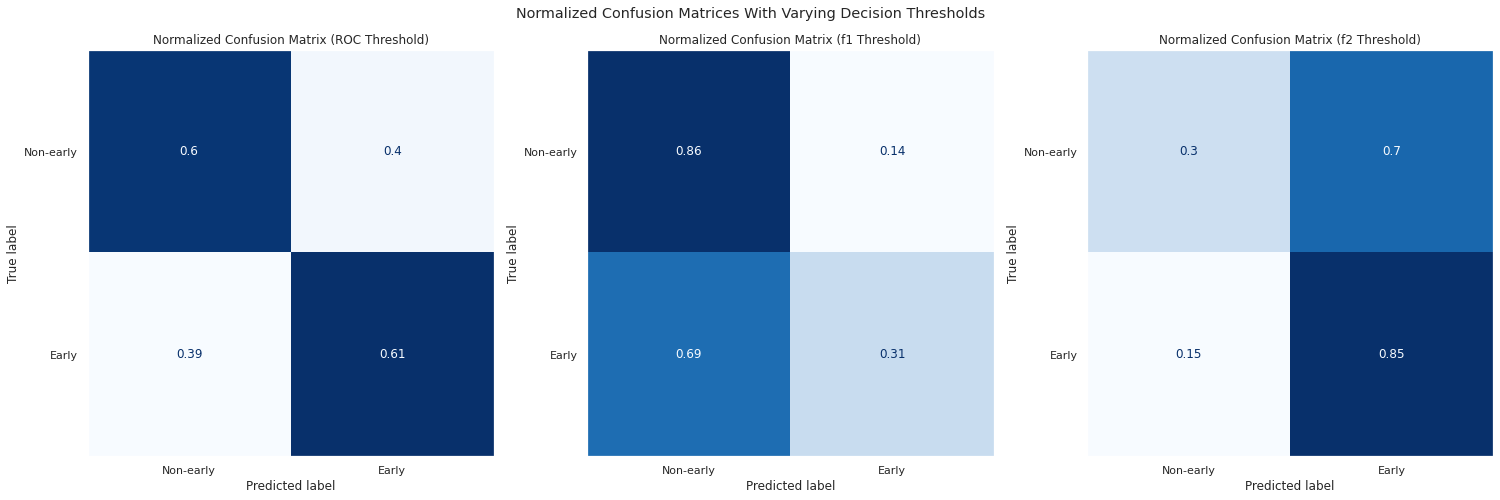

In [45]:
_, axes = plt.subplots(1, 3, figsize=(21, 7))
plot_confusion_matrix_for_threshold(y_pred_proba, y_test, threshold=best_threshold_roc, ax=axes[0], title='Normalized Confusion Matrix (ROC Threshold)')
plot_confusion_matrix_for_threshold(y_pred_proba, y_test, threshold=best_threshold_f1, ax=axes[1], title='Normalized Confusion Matrix (f1 Threshold)')
plot_confusion_matrix_for_threshold(y_pred_proba, y_test, threshold=best_threshold_f2, ax=axes[2], title='Normalized Confusion Matrix (f2 Threshold)')
plt.suptitle('Normalized Confusion Matrices With Varying Decision Thresholds')
plt.tight_layout()

The first confusion matrix optimizes the threshold based on the true and false positive rate. The second and third confusion matrices optimize their thresholds based on the f1 and f2 scores respectively. These priorities can be observed through their recall scores: The third has a significantly greater positive recall score of 0.82, but sacrifices discriminatory power with respect to non-early readmission cases, yielding an negative recall score of only 0.34. Conversely, the f1-score confusion matrix prioritizes the negative recall score, yielding a value of 0.84, and allows its positive recall score to suffer (0.34).

# 8. Costs and Implementation Strategies

Our threshold sensitivity (i.e. whether we'd like to be more sensitive in detecting patients at risk for early readmission) is contigent on (1) the costliness of the practices that accommodate at-risk patients and (2) how much the hospital saves by avoiding patient readmission (also considering that the federal government penalizes hospitals over excess patient readmissions for certain conditions and procedures via the [Hospital Readmissions Reduction Program](https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AcuteInpatientPPS/Readmissions-Reduction-Program)).

## 8.1 Readmission Costs

We estimate the average readmission cost as $15,556 based on the HCUP Statistical Brief [4] hosted by the Agency of Healthcare Research and Quality and adjusting for inflation. Below, we visualize the total hospital readmission cost for patients in our test set as we vary our final classifier's decision threshold.

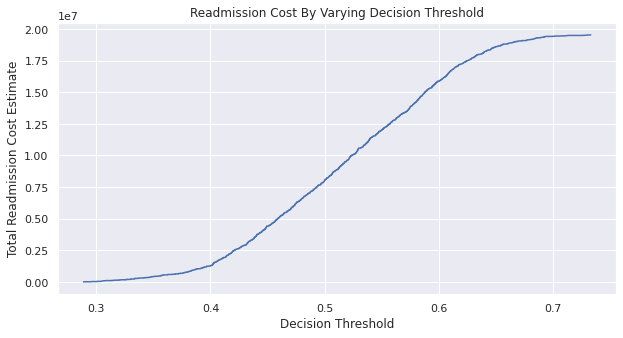

In [50]:
readmission_costs = []
targets = y_test.astype('int')
y_pred_proba = final_classifier.predict_proba(X_test_rfecv)[:, 1]

_, ax = plt.subplots(figsize=(10, 5))

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype('int')
    total_cost = compute_total_readmission_cost(targets, y_pred)
    readmission_costs.append(total_cost)

ax.plot(thresholds, readmission_costs)
ax.set_title('Readmission Cost By Varying Decision Threshold')
ax.set_xlabel('Decision Threshold')
ax.set_ylabel('Total Readmission Cost Estimate');

As we increase the decision threshold, it becomes more difficult to classify a patient with an early readmission label. As a result, we are more likely to classify more future early readmission patients as not-at-risk, thereby yielding more false negatives and high costs if they eventually readmit. Decreasing the decision threshold and making us more likely to classify a patient in the early readmission group increases our false positive rate, which may generate additional costs as well, depending on what type of intervention strategy we decide to employ.

For example, if we ask at-risk patients to stay another day in the hospital, we accept one more day of inpatient care expenses to hopefully reduce the likelihood that the patient will readmit, potentially saving long-term costs. We estimate the average inpatient care expenses per day as $2827, adjusting for inflation [5]. Based on this strategy, we assess the costs of each of the following cases:
- Patients who will readmit and are identified by our model (True Positives) will stay another day in the hospital, but will save on readmission costs.
- Patients who will readmit and are missed by our model (False Negatives) will not stay another day in the hospital, but will cost the hospital readmission costs at some point in the future.
- Patients who will not readmit but are identified as at-risk by our model (False Positives) will stay another day in the hospital needlessly.
- Patients who will not readmit and are identified as not-at-risk by our model (True Negatives) do not incur any additional hospital costs.

We use the term We visualize this operational cost curve below, as function of our classifier's decision threshold:

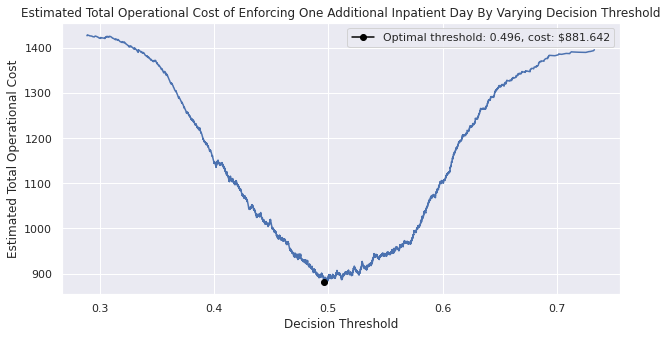

In [47]:
plot_cost_curve(y_pred_proba, targets, thresholds, compute_operational_cost_with_longer_stay, title='Estimated Total Operational Cost of Enforcing One Additional Inpatient Day By Varying Decision Threshold')

We see that the global minimum of this curve is based on a decision threshold that's very similar to the optimal threshold that we found for our ROC. Increasing hospital stay may seem like a reasonable readmission reduction strategy in theory, but Rachoin et al [7] showed that length of stay is associated with a higher likelihood of hospital readmissions. It's likely that there exists a confounding factor that warrants a longer length of stay while also increasing the likelihood of readmission (e.g. severity of principal diagnosis, number of comorbidities) but this may be sufficient in assuming that increasing length of stay alone does not adequately reduce hospital readmission rates. We explore other, more involved intervention strategies in the next section.


## 8.2 Intervention Strategies

We'll now review other potential intervention strategies, all of which were taken from a systematic literature review in Kripalani et al [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4104507/). Most of the following methodologies are multi-faceted; that is, they include multiple individual components to help reduce rehospitalization. These multi-faceted approaches have been shown to reduce readmission rates more significantly than individual approaches.

### 8.2.1 Comprehensive Discharge Planning

Comprehensive discharge planning presented in Naylor et al [2] describes a protocol where a nursing specialist contacts the patient 24-48 hours after the initial hospital admission, assesses the patient and caregiver needs and expectations, and creates a preliminary discharge plan for when the patient is eventually discharged to their home. The specialist visits the patient in the hospital at least every 48 hours to determine if it's necessary adjust the preliminary plan. The nursing specialist calls the patient or their caregiver at least twice within the first 24-48 hours after discharge to assess their condition, educate, and re-adjust the current plan. The specialist is available by phone for at least two weeks after discharge. This protocol demonstrates a combination of personalized discharge planning, patient and caregiver assessment, and ongoing patient-specialist communication in the days following discharge. It has been shown to reduce the number of readmissions in an intervention group of patients aged 70 or older.

The nursing specialists in the study spent, on average, about 3.59 hours on discharge planning and about 46.6 minutes, totalling an average of 4.363 paid hours. If nursing specialists are compensated for about \\$65 dollars an hour, we can visualize the operational cost as a function of our classifier's decision threshold and the average total number of worked hours by the nursing specialist.

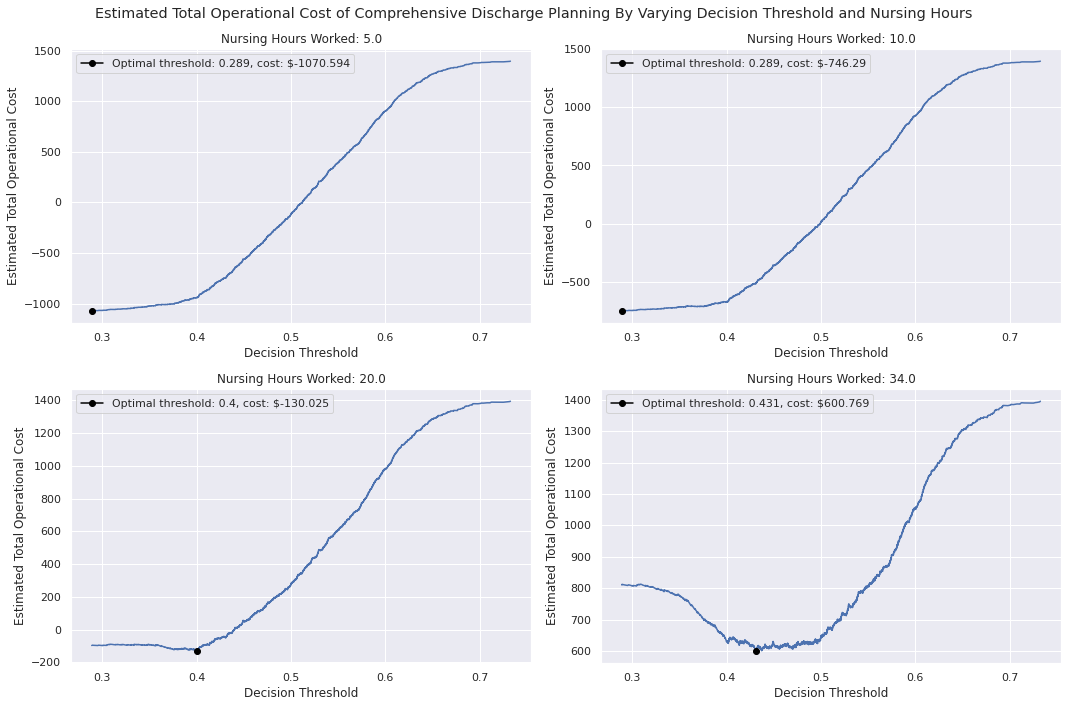

In [48]:
nursing_hours = [5., 10., 20., 34.]
cost_funcs = [partial(compute_average_operational_cost_with_discharge_planning, nursing_specialist_average_num_hours_worked=h) for h in nursing_hours]

_, axes = plt.subplots(2, 2, figsize=(15, 10))
axes_iter = iter(axes.flatten())

for i, f in enumerate(cost_funcs):
    ax = next(axes_iter)
    plot_cost_curve(y_pred_proba, targets, thresholds, f, ax=ax, title=f'Nursing Hours Worked: {nursing_hours[i]}')
    
plt.suptitle('Estimated Total Operational Cost of Comprehensive Discharge Planning By Varying Decision Threshold and Nursing Hours')
plt.tight_layout()

The fewer hours that nursing specialists must work per patient, the more financially viable it is to implement comprehensive discharge planning for all patients. Based on Naylor et al [2], the first figure (top left) is most similar to the nursing hours observed in a randomized clinical trial. Therefore, not only does this strategy appear to be a promising cost-saving approach, it may also displace the need to identify early readmission patients if it proves sufficiently cost-effective for all patients.

### 8.2.2 Project Reengineering Discharge (RED)

Jack et al [3] presented a process called _reengineered discharge_ (RED) to minimize discharge failures, which emphasizes patient education and appointment scheduling. During the patient's hospital stay, a nurse discharge advocate (DA) educates the patient on their relevant diagnoses, future appointments, and the importance of such services in maintaining their health. The DA helps them (1) coordinate convenient appointment times for clinician follow-ups and post-discharge testing, (2) develop a post-discharge medication regimen, and (3) learn an emergency protocol for when a problem arises after they are discharged to their home. After reviewing a detailed summary of their interactions with physicians, the patient is given a written post-discharge plan containing diagnoses, medications, contact information, and other details they have discussed earlier. RED also includes a telephonic component, where pharmacists check-in to reinforce familiarity with the discharge and medication plans. Jack et al observed a significantly lower rate of hospital utilization in the intervention group that leveraged RED than the control group.




# 9. Conclusion
In this notebook, we performed analyzed a baseline model performance of a random forest model. We performed recursive feature elimination and manually pruning of a feature set prior to hyperparameter tuning. We then performed hyperparameter optimization across several experiments, varying kinds of models (random forest, light GBM), objective metrics to maximize (ROC AUC, f1, f2, recall), and datasets (original dataset, RFE-generated dataset, dataset with a subjectively pruned feature set). We found that optimizing a random forest model based on its f2-score over the RFE-generated dataset yielding the best final performance, finding 61% of early readmission patients and 62% of non-early readmission patients in the test set. This demonstrates improvement over the LACE index, an assessment tool to identify early readmission patients, which identified only 49% of early readmission patients and 58% of non-early readmission patients in the test set.

We explored threshold sensitivity, acknowledging that it is a function of the costliness of the intervention practices that accommodate at-risk patients and how much the hospital saves by avoiding patient readmission. We reviewed some examples of intervention policies to examine cost savings across varying decision thresholds of our final classifier.

# 10. Further Work

As mentioned in Kripalani et al [1], the most useful predictive models can be leveraged early enough to allow for intervention. Therefore, using features like whether the patient was discharged to a skilled nursing facilities may be too late for proper intervention. Future work may involve understanding how early prediction must occur to allow for intervention and build a model independent of features that do not meet this temporal criteria. 


# 11. References

1. Kripalani, S., Theobald, C. N., Anctil, B., & Vasilevskis, E. E. (2014). Reducing hospital readmission rates: current strategies and future directions. Annual review of medicine, 65, 471–485. https://doi.org/10.1146/annurev-med-022613-090415
2. Naylor, M., Brooten, D., Jones, R., Lavizzo-Mourey, R., Mezey, M., & Pauly, M. (1994). Comprehensive discharge planning for the hospitalized elderly. A randomized clinical trial. Annals of internal medicine, 120(12), 999–1006. https://doi.org/10.7326/0003-4819-120-12-199406150-00005
3. Jack, B. W., Chetty, V. K., Anthony, D., Greenwald, J. L., Sanchez, G. M., Johnson, A. E., Forsythe, S. R., O'Donnell, J. K., Paasche-Orlow, M. K., Manasseh, C., Martin, S., & Culpepper, L. (2009). A reengineered hospital discharge program to decrease rehospitalization: a randomized trial. Annals of internal medicine, 150(3), 178–187. https://doi.org/10.7326/0003-4819-150-3-200902030-00007
4. Bailey MK (IBM Watson Health), Weiss AJ (IBM Watson Health), Barrett ML (M.L. Barrett, Inc.), Jiang HJ (AHRQ). Characteristics of 30-Day Readmissions, 2010-2016. HCUP Statistical Brief #248. February 2019. Agency for Healthcare Research and Quality, Rockville, MD. www.hcup-us.ahrq.gov/reports/statbriefs/sb248-Hospital-Readmissions-2010-2016.pdf. 
5. Kaiser Permanente Health Costs - Expenses Per Inpatient Day. https://www.kff.org/health-costs/state-indicator/expenses-per-inpatient-day/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D.
6. Coleman, E. A., Parry, C., Chalmers, S., & Min, S. J. (2006). The care transitions intervention: results of a randomized controlled trial. Archives of internal medicine, 166(17), 1822–1828. https://doi.org/10.1001/archinte.166.17.1822
7. Rachoin, J. S., Aplin, K. S., Gandhi, S., Kupersmith, E., & Cerceo, E. (2020). Impact of Length of Stay on Readmission in Hospitalized Patients. Cureus, 12(9), e10669. https://doi.org/10.7759/cureus.10669